In [ ]:
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# paths
csv1 = Path("./prediction/regressor/simplified_with_embeddings.csv")
csv2 = Path("./dataset/swe_bench_token_cost_aggregated_total_with_accuracy.csv")

# ------------------------------------------------------------------
# load
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2, usecols=["instance_id", "difficulty", "acc_run1", "acc_run2", "acc_run3", "acc_run4"])   # include accuracy columns

# ------------------------------------------------------------------
# merge  (left-join keeps every row from df1; adds difficulty where it matches)
merged = df1.merge(df2, on="instance_id", how="left")

# ------------------------------------------------------------------
# inspect / save
display(merged)   # or print(merged.head())

# Print number of instances for each difficulty level
print("\nNumber of instances by difficulty level:")
difficulty_counts = merged['difficulty'].value_counts()
for difficulty in ["<15 min fix", "15 min - 1 hour", "1-4 hours", ">4 hours"]:
    count = difficulty_counts.get(difficulty, 0)
    print(f"{difficulty}: {count} instances")

# If you’d like to overwrite csv1 (or write to a new location) uncomment:
# merged.to_csv(csv1, index=False)


,repo,instance_id,problem_statement,total_prompt_tokens_mean,total_completion_tokens_mean,total_tool_usages_mean,embedding,difficulty,acc_run1,acc_run2,acc_run3,acc_run4
0,astropy/astropy,astropy__astropy-12907,Modeling's `separability_matrix` does not comp...,1568999.00,17198.00,50.75,"[0.00021230339189060032, -0.013948917388916016...",15 min - 1 hour,1,1,1,1
1,astropy/astropy,astropy__astropy-13033,TimeSeries: misleading exception when required...,539891.50,7250.25,29.25,"[0.004563741851598024, 0.008466904982924461, -...",15 min - 1 hour,0,0,0,0
2,astropy/astropy,astropy__astropy-13236,Consider removing auto-transform of structured...,1176829.50,10014.75,42.75,"[-0.02539057470858097, -0.013061127625405788, ...",15 min - 1 hour,0,0,0,0
3,astropy/astropy,astropy__astropy-13398,A direct approach to ITRS to Observed transfor...,1124249.00,11801.50,36.50,"[-0.02201954275369644, 0.0009095664136111736, ...",1-4 hours,0,0,0,0
4,astropy/astropy,astropy__astropy-13453,ASCII table output to HTML does not support su...,4079917.00,29786.00,76.25,"[0.010511836037039757, 0.000437634764239192, -...",15 min - 1 hour,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,sympy/sympy,sympy__sympy-24213,collect_factor_and_dimension does not detect e...,1033034.75,9828.25,38.50,"[0.012254624627530575, -0.010718471370637417, ...",15 min - 1 hour,1,1,1,1
496,sympy/sympy,sympy__sympy-24443,`_check_homomorphism` is broken on Permutation...,5594264.75,54191.25,76.50,"[-0.019063854590058327, 0.0025745490565896034,...",15 min - 1 hour,1,0,1,1
497,sympy/sympy,sympy__sympy-24539,`PolyElement.as_expr()` not accepting symbols\...,479623.50,7013.00,28.00,"[0.0043180244974792, 0.020639615133404732, -0....",<15 min fix,1,1,1,1
498,sympy/sympy,sympy__sympy-24562,"Rational calc value error\npython 3.11, sympy ...",920810.75,10741.50,37.00,"[-0.02259681560099125, -0.028695203363895416, ...",<15 min fix,1,1,1,1



Number of instances by difficulty level:
<15 min fix: 194 instances
15 min - 1 hour: 261 instances
1-4 hours: 42 instances
>4 hours: 3 instances


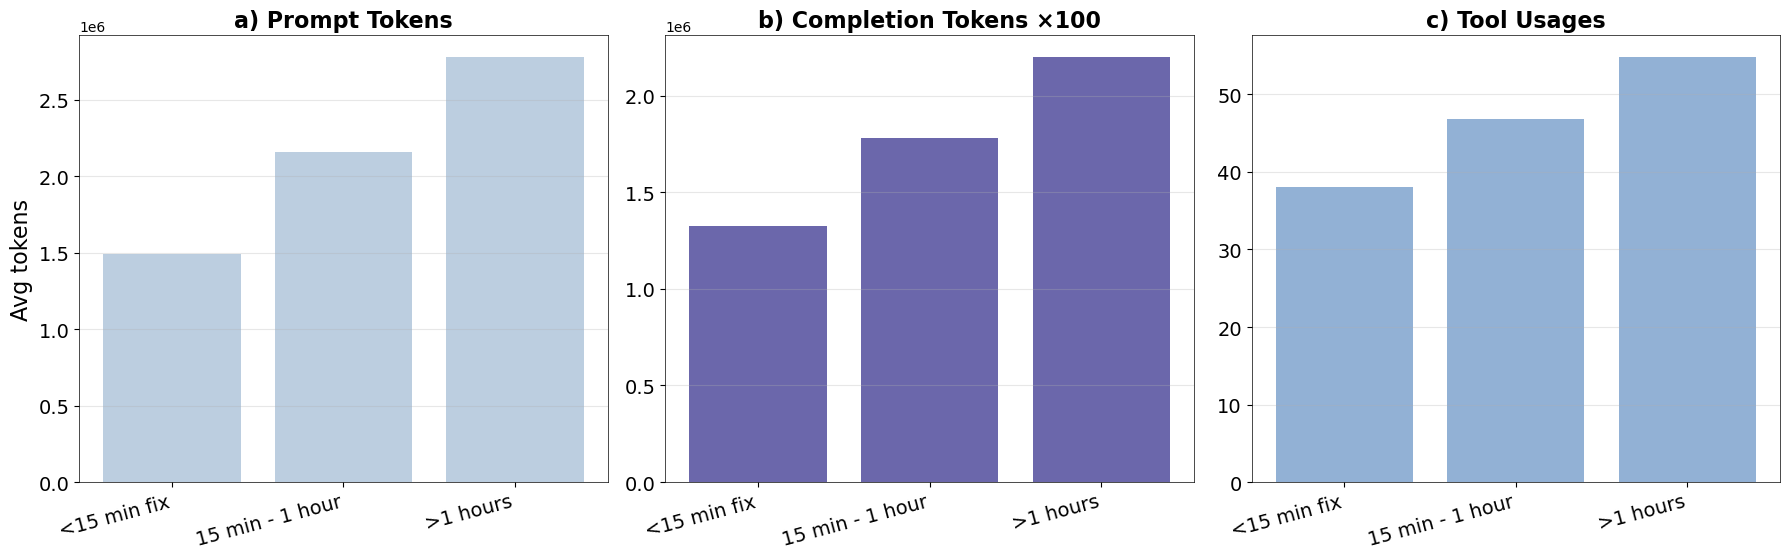

In [3]:
# --- Collapse difficulty levels (same as before) ----
new_order = ["<15 min fix", "15 min - 1 hour", ">1 hours"]

def _collapse_diff(x: str) -> str:
    if x in ["1-4 hours", ">4 hours"]:
        return ">1 hours"
    return x

merged2 = merged.copy()
merged2["difficulty"] = merged2["difficulty"].map(_collapse_diff)
merged2["difficulty"] = pd.Categorical(merged2["difficulty"], categories=new_order, ordered=True)

# Recompute summary + accuracy
summary2 = (
    merged2.groupby("difficulty", observed=True)[cols_to_avg]
           .mean()
           .loc[new_order]
           .reset_index()
)

accuracy_data2 = []
for diff in new_order:
    g = merged2[merged2["difficulty"] == diff]
    if len(g) > 0:
        total_resolved = g[["acc_run1", "acc_run2", "acc_run3", "acc_run4"]].sum().sum()
        total_possible = len(g) * 4
        acc = total_resolved / total_possible if total_possible > 0 else 0.0
    else:
        acc = 0.0
    accuracy_data2.append(acc)

summary2["completion_scaled"] = summary2["total_completion_tokens_mean"] * 100
summary2["accuracy"] = accuracy_data2

# --- Plot 3 metrics in a row, fonts aligned with original ----------------------------
colors = {
    "prompt": "#ACC2D9",
    "completion": "#464196",
    "tool": "#779ECB",
}

x = np.arange(len(new_order))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# 1) Prompt tokens
axes[0].bar(x, summary2["total_prompt_tokens_mean"], alpha=0.8, color=colors["prompt"])
axes[0].set_title("a) Prompt Tokens", fontsize=16, fontweight="bold")
axes[0].set_ylabel("Avg tokens", fontsize=16)

# 2) Completion tokens ×100
axes[1].bar(x, summary2["completion_scaled"], alpha=0.8, color=colors["completion"])
axes[1].set_title("b) Completion Tokens ×100", fontsize=16, fontweight="bold")

# 3) Tool usages
axes[2].bar(x, summary2["total_tool_usages_mean"], alpha=0.8, color=colors["tool"])
axes[2].set_title("c) Tool Usages", fontsize=16, fontweight="bold")

# Common cosmetics
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(new_order, rotation=15, ha="right", fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    # Keep full black frame like original
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

# fig.suptitle("Average Tokens and Tool Usages by Difficulty", fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("difficulty_metrics_row.png", dpi=300, bbox_inches='tight')
plt.show()


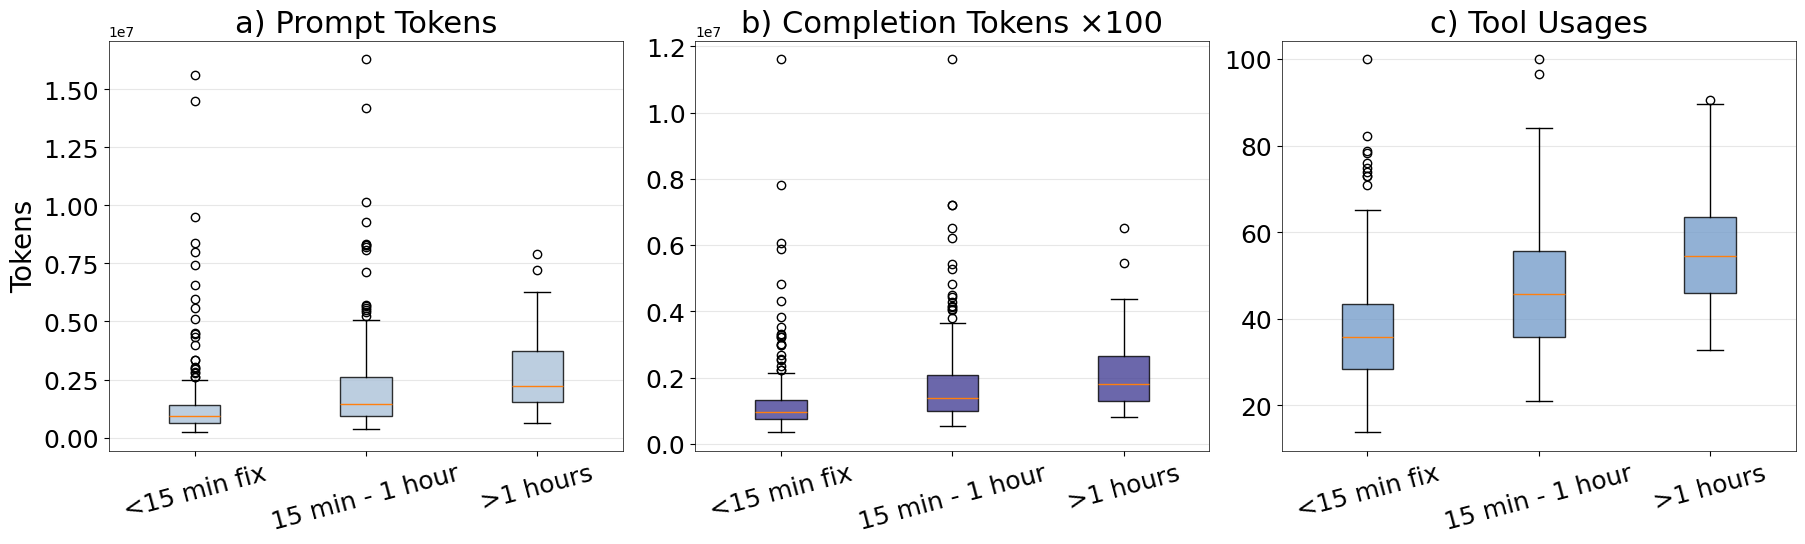

In [4]:
# --- Box plot version (3 subplots) ----------------------------
colors = {
    "prompt": "#ACC2D9",
    "completion": "#464196",
    "tool": "#779ECB",
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Consistent numeric positions for ALL subplots
pos = np.arange(1, len(new_order) + 1)

# Prepare data for the box plots
prompt_data = [merged2[merged2["difficulty"] == diff]["total_prompt_tokens_mean"].dropna().values
               for diff in new_order]
completion_data = [merged2[merged2["difficulty"] == diff]["total_completion_tokens_mean"].dropna().values * 100
                   for diff in new_order]
tool_data = [merged2[merged2["difficulty"] == diff]["total_tool_usages_mean"].dropna().values
             for diff in new_order]

# 1) Prompt tokens (box)
bp1 = axes[0].boxplot(prompt_data, positions=pos, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor(colors["prompt"]); patch.set_alpha(0.8)
axes[0].set_title("a) Prompt Tokens", fontsize=22)
axes[0].set_ylabel("Tokens", fontsize=20)
axes[0].set_xticks(pos); axes[0].set_xticklabels(new_order)

# 2) Completion tokens ×100 (box)
bp2 = axes[1].boxplot(completion_data, positions=pos, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor(colors["completion"]); patch.set_alpha(0.8)
axes[1].set_title("b) Completion Tokens ×100", fontsize=22)
axes[1].set_xticks(pos); axes[1].set_xticklabels(new_order)

# 3) Tool usages (box)
bp3 = axes[2].boxplot(tool_data, positions=pos, patch_artist=True)
for patch in bp3['boxes']:
    patch.set_facecolor(colors["tool"]); patch.set_alpha(0.8)
axes[2].set_title("c) Tool Usages", fontsize=22)
axes[2].set_xticks(pos); axes[2].set_xticklabels(new_order)

# Common cosmetics
for ax in axes:
    ax.tick_params(axis='x', labelsize=18, rotation=15)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, axis='y', alpha=0.3)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("difficulty_metrics_box_and_bar.png", dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# Compute cross-group comparisons on total tokens between <15 min fix and >1 hours
import numpy as np
import pandas as pd

# Ensure we have the collapsed difficulty frame `merged2`
assert 'merged2' in globals(), "merged2 not found. Run the previous cells first."

# Total tokens per instance
merged2 = merged2.copy()
merged2['total_tokens'] = (
    merged2['total_prompt_tokens_mean'].fillna(0)
    + merged2['total_completion_tokens_mean'].fillna(0)
)

# Focus on the two groups of interest
lt15_label = '<15 min fix'
gt1h_label = '>1 hours'

lt15 = merged2[merged2['difficulty'] == lt15_label].dropna(subset=['total_tokens'])
gt1h = merged2[merged2['difficulty'] == gt1h_label].dropna(subset=['total_tokens'])

n_lt15 = len(lt15)
n_gt1h = len(gt1h)

# If any group is empty, handle gracefully
if n_lt15 == 0 or n_gt1h == 0:
    print(f"Insufficient data: <15 min fix count={n_lt15}, >1 hours count={n_gt1h}")
else:
    # Thresholds: use the mean total tokens of the target group
    gt1h_mean = gt1h['total_tokens'].mean()
    lt15_mean = lt15['total_tokens'].mean()

    # 1) How many <15 min fix instances cost more total tokens than the >1 hours mean?
    lt15_more_than_gt1h_mean = int((lt15['total_tokens'] > gt1h_mean).sum())
    lt15_more_pct = 100.0 * lt15_more_than_gt1h_mean / n_lt15 if n_lt15 else 0.0

    # 2) How many >1 hours instances cost less total tokens than the <15 min fix mean?
    gt1h_less_than_lt15_mean = int((gt1h['total_tokens'] < lt15_mean).sum())
    gt1h_less_pct = 100.0 * gt1h_less_than_lt15_mean / n_gt1h if n_gt1h else 0.0

    # Print results
    print(f"Comparison based on per-group mean total tokens")
    print(f"- {lt15_label} vs {gt1h_label} mean:")
    print(f"  Count: {lt15_more_than_gt1h_mean} out of {n_lt15}  |  Percentage: {lt15_more_pct:.2f}%")
    print(f"- {gt1h_label} vs {lt15_label} mean:")
    print(f"  Count: {gt1h_less_than_lt15_mean} out of {n_gt1h}  |  Percentage: {gt1h_less_pct:.2f}%")

    # (Optional) Show the means for context
    print(f"\nGroup means (total tokens): {lt15_label}={lt15_mean:.2f}, {gt1h_label}={gt1h_mean:.2f}")


Comparison based on per-group mean total tokens
- <15 min fix vs >1 hours mean:
  Count: 20 out of 194  |  Percentage: 10.31%
- >1 hours vs <15 min fix mean:
  Count: 11 out of 45  |  Percentage: 24.44%

Group means (total tokens): <15 min fix=1501484.30, >1 hours=2802511.18
